# Homework 3  - Part B


###### Roll Number: 21100072

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display
import numpy as np
import pandas as pd
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 21100072
np.random.seed(your_id)

Using TensorFlow backend.
C:\Users\Zohair\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Zohair\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Zohair\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Zohair\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

###### Hyperparameters

In [2]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape = (32,32,3)
images_dir = './images/cifar/'
epochs = 25 
all_histories = []
model_names=[]

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [4]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
train_files = glob.glob(train_dir+"*.png")
test_files = glob.glob(test_dir+"*.png")

# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
classes = []
with open(label_dir, "r") as f:
    classes = f.read().splitlines()
print("Total training sample: ", len(train_files))
# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
train_files, val_files = train_test_split(train_files, test_size=0.2)
print("Training sample after split:",len(train_files))
print("Validation set: ",len(val_files))

image = cv2.imread (test_files[1])
# print(image.shape)
print(image)
print(image.shape)
# plt.imshow(image)

Total training sample:  50000
Training sample after split: 40000
Validation set:  10000
[[[ 13  17  18]
  [ 15  20  20]
  [ 17  22  21]
  ...
  [ 31  36  43]
  [ 41  55  75]
  [ 53  73 103]]

 [[ 64  72  77]
  [ 44  48  47]
  [ 14  19  18]
  ...
  [ 40  48  63]
  [ 52  69  98]
  [ 47  63  91]]

 [[ 80  87  94]
  [ 91  96 103]
  [ 26  29  31]
  ...
  [ 50  69  91]
  [ 49  68  97]
  [ 46  66  90]]

 ...

 [[ 58  74 101]
  [ 60  77 102]
  [ 55  76 101]
  ...
  [ 47  68  92]
  [ 26  40  55]
  [ 21  24  32]]

 [[ 57  77 102]
  [ 57  77 102]
  [ 58  78 103]
  ...
  [ 34  47  69]
  [ 24  27  35]
  [ 24  26  34]]

 [[ 55  75 101]
  [ 57  77 102]
  [ 57  80 105]
  ...
  [ 27  32  44]
  [ 26  28  35]
  [ 27  29  37]]]
(32, 32, 3)


Fixing file directories by classifying images in the training folder into subdirectories

### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [15]:
def preprocessing_norm(images):
    images=np.array(images)
    images=images.astype('float64')
    for i in range(len(images)):
        images[i]=np.divide(images[i], 255)
    return images.tolist()
# print(image[0])
# image=preprocessing_norm([image])
# print(image)

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [16]:
def preprocessing_meanShift(images):
    images=np.array(images) #if it is a list
    images=images.astype('float64')
    for i in range(images.shape[0]):
        for c in range(images.shape[3]):
            mean=np.mean(images[i,:,:,c])
            std=np.std(images[i,:,:,c])
            images[i,:,:c]=np.divide(images[i,:,:c]-mean, std)
    return images.tolist()
            
# print(image[0])
# image=preprocessing_meanShift([image])
# print(image)

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [17]:
def one_hot_encode(label):
    ind=classes.index(label)
    res=[0]*len(classes)
    res[ind]=1
    return res
def data_generator(paths , batch_size = 32, preprocessing = None):
    res=[] #images
    labels=[] #respective labels
    count=1
    while True:
        for image in paths:
#             print(preprocessing)
            y=os.path.basename(image)
            x=y.split("_")
            x=x[1].split(".")[0]
            #one hot encode the 
#             print(x)
#             print(classes.index(x))
#             labels.append(classes.index(x))
            labels.append(one_hot_encode(x))
            im=cv2.imread(image)
    #         plt.imshow(im)
    #         print(x)
            res.append(im)
            if count%batch_size==0:
                if preprocessing!=None:
#                     print(preprocessing)
                    if preprocessing=="preprocessing_norm":
                        res=preprocessing_norm(res)
                    elif preprocessing=="preprocessing_meanShift":
                        res=preprocessing_meanShift(res)
                yield np.asarray(res),np.asarray(labels)
                res.clear()
                labels.clear()
            count+=1

# images=data_generator(train_files)
# x=next(images)
# y=next(images)
# z=next(images)
# print(z[0])
# print(z[1])
# plt.imshow(images[0][0])
    #preprocess after getting images

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [18]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu')(input_img)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_initial = Model(inputs=input_img, outputs=output_class)

#### Compile model and plot

In [19]:
model_name = 'base_model'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
   

In [20]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)

# Use the appropriate loss function and compile the model
model_initial.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

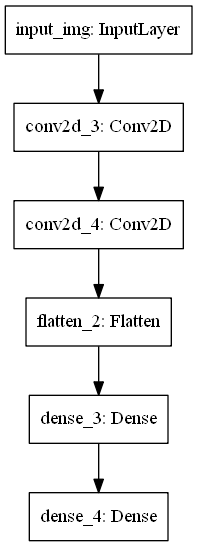

In [21]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

In [22]:
model_initial.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 2)         56        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        304       
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                250900    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 251,470
Trainable params: 251,470
Non-trainable params: 0
_____________________________________________________

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [23]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [24]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [25]:
# Create three generators: For training your model, for validation, for testing.
train_gen=data_generator(train_files)
test_gen=data_generator(test_files)
val_gen=data_generator(val_files)

In [26]:
# Start training your model here
# print(len(val_files))
# print(batch_size)
# print(len(val_files)//batch_size)
# print(len(train_files)//batch_size)
hist_initial = model_initial.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)

all_histories.append(hist_initial)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
625/625 [==============================] - 81s 130ms/step - loss: 2.3931 - accuracy: 0.0958 - val_loss: 2.3096 - val_accuracy: 0.0974

Epoch 00001: val_loss improved from inf to 2.30960, saving model to base_model/base_model-01-2.31.h5
Epoch 2/25
625/625 [==============================] - 81s 129ms/step - loss: 2.3050 - accuracy: 0.0999 - val_loss: 2.3136 - val_accuracy: 0.0998

Epoch 00002: val_loss did not improve from 2.30960
Epoch 3/25
625/625 [==============================] - 33s 52ms/step - loss: 2.3055 - accuracy: 0.0983 - val_loss: 2.3387 - val_accuracy: 0.0970

Epoch 00003: val_loss did not improve from 2.30960
Epoch 4/25
625/625 [==============================] - 32s 51ms/step - loss: 2.3061 - accuracy: 0.1011 - val_loss: 2.2917 - val_accuracy: 0.0992

Epoch 00004: val_loss improved from 2.30960 to 2.29166, saving model to base_model/base_model-04-2.29.h5
Epoch 5/25
625/625 [==============================] - 32s 50ms

In [27]:
# print(hist_initial.history)

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [28]:
input_img = Input(shape=(input_shape), name='input_img')

In [29]:
model_name = 'model_preprocessed_input'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [30]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu')(input_img)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_preprocessed = Model(inputs=input_img, outputs=output_class)

In [31]:
# You may tweak this Learning Rate
adam = Adam(lr=0.001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

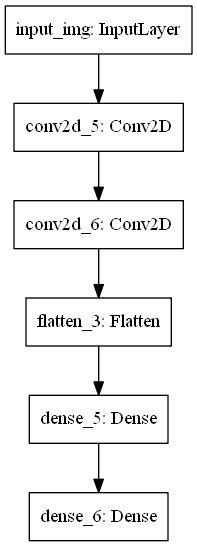

In [32]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [33]:
model_preprocessed.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 2)         56        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        304       
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                250900    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
Total params: 251,470
Trainable params: 251,470
Non-trainable params: 0
_____________________________________________________

In [34]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [35]:
# Create three generators again
# train_gen=data_generator(train_files, batch_size,"preprocessing_meanShift")
# test_gen=data_generator(test_files, batch_size,"preprocessing_meanShift")
# val_gen=data_generator(val_files, batch_size,"preprocessing_meanShift")

train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

In [36]:
hist_preprocessed = model_preprocessed.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
all_histories.append(hist_preprocessed)

Epoch 1/25
625/625 [==============================] - 156s 249ms/step - loss: 1.8229 - accuracy: 0.3463 - val_loss: 1.7557 - val_accuracy: 0.3813

Epoch 00001: val_loss improved from inf to 1.75569, saving model to model_preprocessed_input/model_preprocessed_input-01-1.76.h5
Epoch 2/25
625/625 [==============================] - 147s 235ms/step - loss: 1.6866 - accuracy: 0.4035 - val_loss: 1.8206 - val_accuracy: 0.3977

Epoch 00002: val_loss did not improve from 1.75569
Epoch 3/25
625/625 [==============================] - 151s 242ms/step - loss: 1.6285 - accuracy: 0.4253 - val_loss: 1.6769 - val_accuracy: 0.4009

Epoch 00003: val_loss improved from 1.75569 to 1.67688, saving model to model_preprocessed_input/model_preprocessed_input-03-1.68.h5
Epoch 4/25
625/625 [==============================] - 148s 236ms/step - loss: 1.5839 - accuracy: 0.4421 - val_loss: 1.7531 - val_accuracy: 0.4006

Epoch 00004: val_loss did not improve from 1.67688
Epoch 5/25
625/625 [============================

C:\Users\Zohair\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100487). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


625/625 [==============================] - 170s 272ms/step - loss: 1.3619 - accuracy: 0.5212 - val_loss: 2.0058 - val_accuracy: 0.3635

Epoch 00014: val_loss did not improve from 1.67688
Epoch 15/25
625/625 [==============================] - 172s 275ms/step - loss: 1.3452 - accuracy: 0.5296 - val_loss: 2.0351 - val_accuracy: 0.3577

Epoch 00015: val_loss did not improve from 1.67688
Epoch 16/25
625/625 [==============================] - 170s 272ms/step - loss: 1.3306 - accuracy: 0.5331 - val_loss: 2.0026 - val_accuracy: 0.3498

Epoch 00016: val_loss did not improve from 1.67688
Epoch 17/25
625/625 [==============================] - 172s 276ms/step - loss: 1.3208 - accuracy: 0.5346 - val_loss: 2.0066 - val_accuracy: 0.3506

Epoch 00017: val_loss did not improve from 1.67688
Epoch 18/25
625/625 [==============================] - 195s 311ms/step - loss: 1.3183 - accuracy: 0.5335 - val_loss: 1.9533 - val_accuracy: 0.3576

Epoch 00018: val_loss did not improve from 1.67688
Epoch 19/25
625/6

C:\Users\Zohair\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101021). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


625/625 [==============================] - 200s 319ms/step - loss: 1.2819 - accuracy: 0.5465 - val_loss: 2.0489 - val_accuracy: 0.3558

Epoch 00021: val_loss did not improve from 1.67688
Epoch 22/25
625/625 [==============================] - 194s 310ms/step - loss: 1.2619 - accuracy: 0.5554 - val_loss: 1.7541 - val_accuracy: 0.3553

Epoch 00022: val_loss did not improve from 1.67688
Epoch 23/25
625/625 [==============================] - 195s 312ms/step - loss: 1.2496 - accuracy: 0.5612 - val_loss: 1.7640 - val_accuracy: 0.3511

Epoch 00023: val_loss did not improve from 1.67688
Epoch 24/25
625/625 [==============================] - 192s 308ms/step - loss: 1.2468 - accuracy: 0.5623 - val_loss: 1.8082 - val_accuracy: 0.3469

Epoch 00024: val_loss did not improve from 1.67688
Epoch 25/25
625/625 [==============================] - 152s 242ms/step - loss: 1.2504 - accuracy: 0.5599 - val_loss: 1.9009 - val_accuracy: 0.3457

Epoch 00025: val_loss did not improve from 1.67688


### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [37]:
model_name = 'model_pooling'
model_names.append(model_name)
input_img = Input(shape=(input_shape), name='input_img')
model_pooled = None

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [78]:
input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu', name="c1")(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh', name='c2')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_pooled = Model(inputs=input_img, outputs=output_class)

In [39]:
adam = Adam(lr=0.001)
model_pooled.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

In [40]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 2)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1154

In [41]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [42]:
# Create generators
train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

In [43]:
hist_pooled = model_pooled.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
all_histories.append(hist_pooled)

Epoch 1/25
625/625 [==============================] - 165s 264ms/step - loss: 1.8794 - accuracy: 0.3314 - val_loss: 1.6581 - val_accuracy: 0.4133

Epoch 00001: val_loss improved from inf to 1.65811, saving model to model_pooling/model_pooling-01-1.66.h5
Epoch 2/25
625/625 [==============================] - 171s 273ms/step - loss: 1.6158 - accuracy: 0.4306 - val_loss: 1.6280 - val_accuracy: 0.4530

Epoch 00002: val_loss improved from 1.65811 to 1.62796, saving model to model_pooling/model_pooling-02-1.63.h5
Epoch 3/25
625/625 [==============================] - 163s 261ms/step - loss: 1.5148 - accuracy: 0.4652 - val_loss: 1.4515 - val_accuracy: 0.4691

Epoch 00003: val_loss improved from 1.62796 to 1.45152, saving model to model_pooling/model_pooling-03-1.45.h5
Epoch 4/25
625/625 [==============================] - 136s 217ms/step - loss: 1.4538 - accuracy: 0.4866 - val_loss: 1.3137 - val_accuracy: 0.4871

Epoch 00004: val_loss improved from 1.45152 to 1.31366, saving model to model_pooli

C:\Users\Zohair\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.219415). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


625/625 [==============================] - 164s 262ms/step - loss: 1.1674 - accuracy: 0.5888 - val_loss: 1.1575 - val_accuracy: 0.5458

Epoch 00022: val_loss improved from 1.24675 to 1.15745, saving model to model_pooling/model_pooling-22-1.16.h5
Epoch 23/25
625/625 [==============================] - 130s 209ms/step - loss: 1.1616 - accuracy: 0.5913 - val_loss: 1.2470 - val_accuracy: 0.5475

Epoch 00023: val_loss did not improve from 1.15745
Epoch 24/25
625/625 [==============================] - 130s 208ms/step - loss: 1.1560 - accuracy: 0.5934 - val_loss: 1.2113 - val_accuracy: 0.5462

Epoch 00024: val_loss did not improve from 1.15745
Epoch 25/25
625/625 [==============================] - 133s 213ms/step - loss: 1.1507 - accuracy: 0.5951 - val_loss: 1.1125 - val_accuracy: 0.5472

Epoch 00025: val_loss improved from 1.15745 to 1.11249, saving model to model_pooling/model_pooling-25-1.11.h5


### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [44]:
model_name = 'model_dropout'
model_names.append(model_name)
input_img = Input(shape=(input_shape), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu')(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_dropout = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [45]:
adam = Adam(lr=0.001)
model_dropout.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

In [46]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 2)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 2)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 16)          0   

In [47]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [48]:
# Create three Generators
# train_gen=data_generator(train_files, batch_size,"preprocessing_meanShift")
# test_gen=data_generator(test_files, batch_size,"preprocessing_meanShift")
# val_gen=data_generator(val_files, batch_size,"preprocessing_meanShift")

train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

In [49]:
hist_dropout = model_dropout.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)

all_histories.append(hist_dropout)

Epoch 1/25
625/625 [==============================] - 136s 217ms/step - loss: 1.9830 - accuracy: 0.2667 - val_loss: 1.7511 - val_accuracy: 0.3485

Epoch 00001: val_loss improved from inf to 1.75111, saving model to model_dropout/model_dropout-01-1.75.h5
Epoch 2/25
625/625 [==============================] - 131s 210ms/step - loss: 1.8357 - accuracy: 0.3284 - val_loss: 1.7106 - val_accuracy: 0.3666

Epoch 00002: val_loss improved from 1.75111 to 1.71059, saving model to model_dropout/model_dropout-02-1.71.h5
Epoch 3/25
625/625 [==============================] - 134s 214ms/step - loss: 1.7885 - accuracy: 0.3444 - val_loss: 1.7878 - val_accuracy: 0.3709

Epoch 00003: val_loss did not improve from 1.71059
Epoch 4/25
625/625 [==============================] - 128s 206ms/step - loss: 1.7616 - accuracy: 0.3575 - val_loss: 1.8412 - val_accuracy: 0.3773

Epoch 00004: val_loss did not improve from 1.71059
Epoch 5/25
625/625 [==============================] - 129s 206ms/step - loss: 1.7437 - accur

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [50]:
model_name = 'model_batch_normalized'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [51]:
input_img = Input(shape=(input_shape), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu')(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)
layer=BatchNormalization()(layer)
layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
layer = Dropout(rate=0.5)(layer)
layer=BatchNormalization()(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_normalized = Model(inputs=input_img, outputs=output_class)

In [52]:
adam = Adam(lr=0.001)
model_normalized.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

In [53]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 2)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 2)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 16)          0   

In [54]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [55]:
# Create three generators
train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

In [56]:
hist_normalized =  model_normalized.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
all_histories.append(hist_normalized)

Epoch 1/25
625/625 [==============================] - 140s 225ms/step - loss: 2.1341 - accuracy: 0.2181 - val_loss: 1.8459 - val_accuracy: 0.3025

Epoch 00001: val_loss improved from inf to 1.84595, saving model to model_batch_normalized/model_batch_normalized-01-1.85.h5
Epoch 2/25
625/625 [==============================] - 130s 208ms/step - loss: 1.8934 - accuracy: 0.2893 - val_loss: 1.8176 - val_accuracy: 0.2893

Epoch 00002: val_loss improved from 1.84595 to 1.81764, saving model to model_batch_normalized/model_batch_normalized-02-1.82.h5
Epoch 3/25
625/625 [==============================] - 137s 220ms/step - loss: 1.8342 - accuracy: 0.3186 - val_loss: 1.8009 - val_accuracy: 0.3028

Epoch 00003: val_loss improved from 1.81764 to 1.80092, saving model to model_batch_normalized/model_batch_normalized-03-1.80.h5
Epoch 4/25
625/625 [==============================] - 131s 209ms/step - loss: 1.8088 - accuracy: 0.3327 - val_loss: 1.8784 - val_accuracy: 0.3073

Epoch 00004: val_loss did not

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [57]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

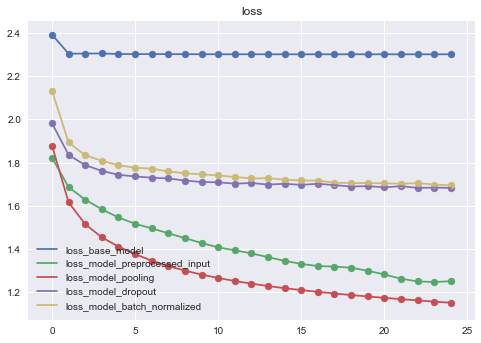

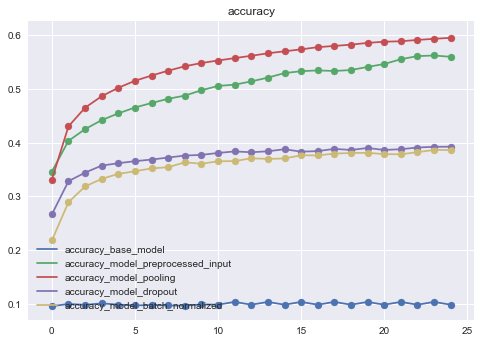

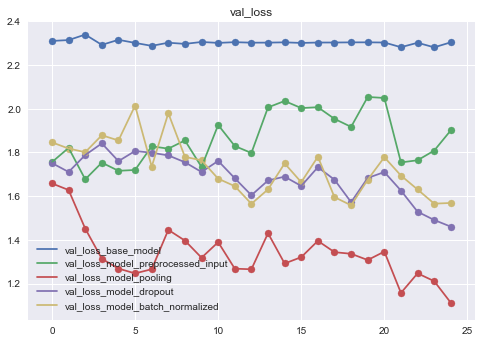

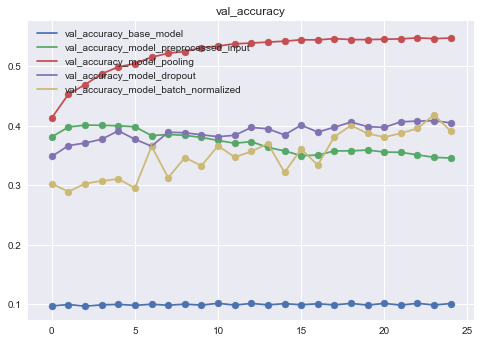

In [58]:
# Plot histories of all models
#give different metrics
plotHistory(all_histories, model_names, "loss")
plotHistory(all_histories, model_names, "accuracy")
plotHistory(all_histories, model_names, "val_loss")
plotHistory(all_histories, model_names, "val_accuracy")

From the above plots, we can deduce that the model with the best performance is the one with pooling and preprocessing but not drop out and batch normalization. The reason for this may be that preprocessing standardized the data and pooling shrinked it to successfully learn the features but drop out was too high leading to a fall in accuracy and increase in loss due to less neurons at work. Batch normalization too seemed to add complexity rather than reduce it.

#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

**Add cells to include loss plots**

##### Add your analysis here

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

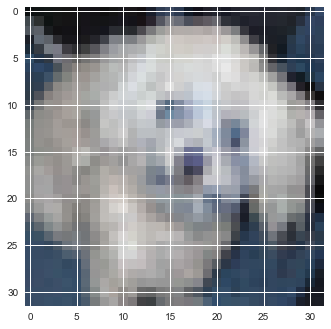

In [59]:
# Load any image here
test_image = cv2.imread (test_files[1])

plt.imshow(test_image)

array([5], dtype=int64)

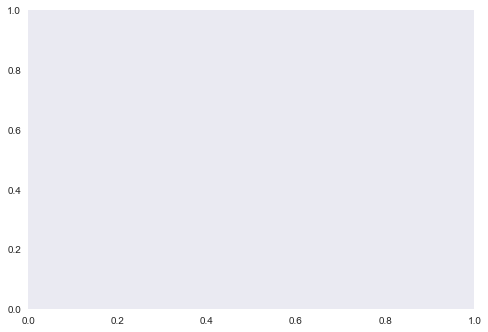

In [64]:
plt.gca().grid(False);

test_reshaped = test_image.reshape((1,32,32,3))

# Get a prediction from ANY ONE of your models and output its label
model_pooled.predict(test_reshaped).argmax(axis=1)
#correctly labelled as 5 or dog

In [79]:
# Create a Model from the Input layer to a Convolutional Layer
new_model = Model(inputs=input_img, 
                  outputs=model_pooled.get_layer('c1').output)

In [80]:
# Get a prediction for your chosen image using this model
predicted_activations = new_model.predict(test_reshaped)

IndexError: index 2 is out of bounds for axis 3 with size 2

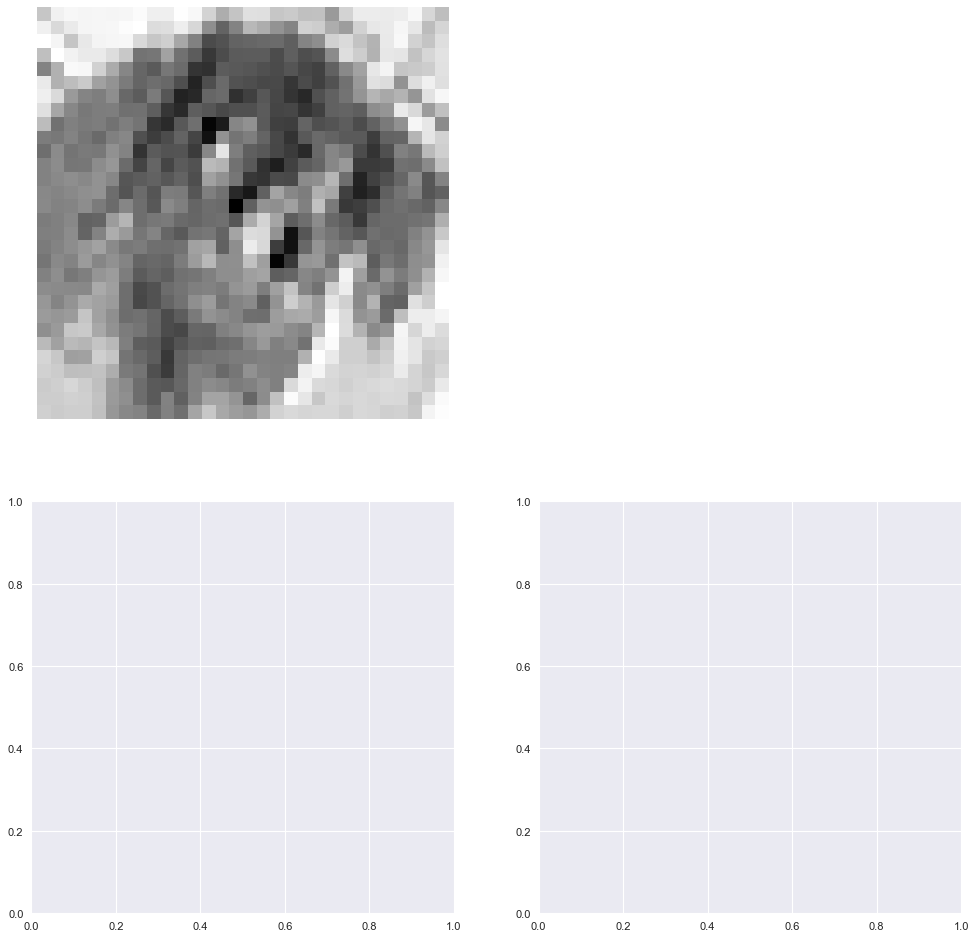

In [87]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [88]:
# Create another model to visualize activations from ANOTHER convolutional layer
new_model = Model(inputs=input_img, 
                  outputs=model_pooled.get_layer('c2').output)

In [89]:
# You may rename this variable
second_predicted_activations = new_model.predict(test_reshaped)

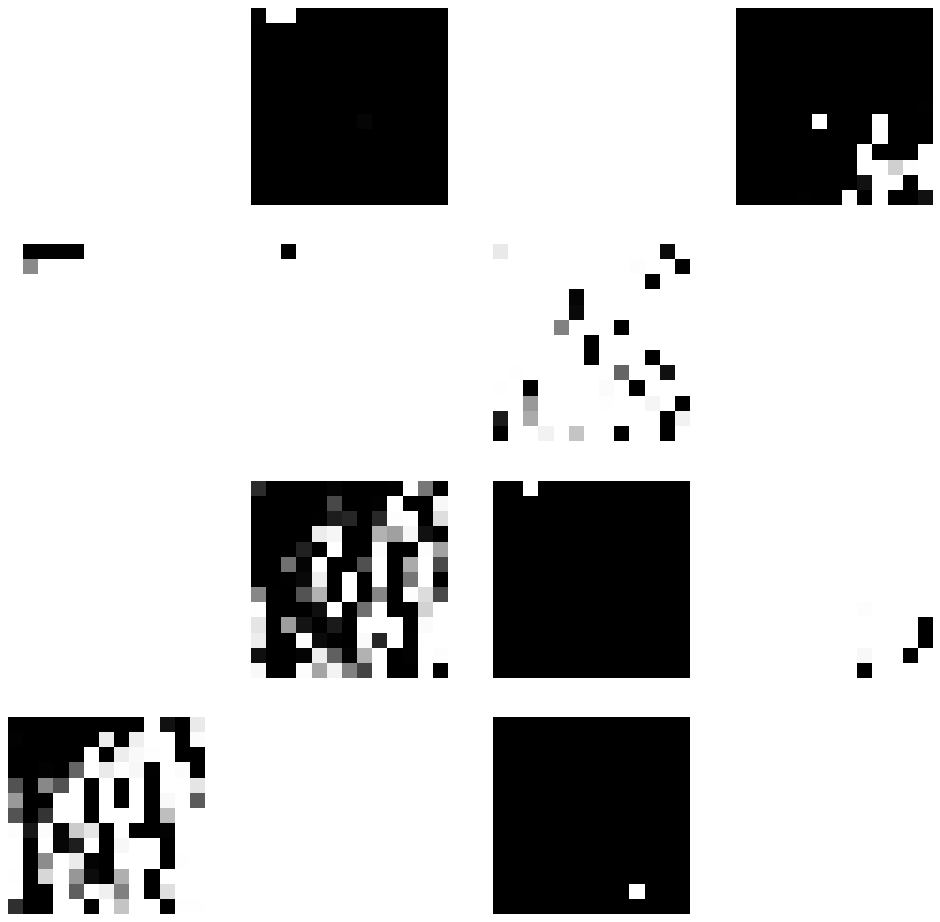

In [90]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?
Ans. The model is able to learn the fuzzy background and then the darker parts of the picture. By adding more layer, or model could learn more complicated features.

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [95]:
epochs = 1 #to save time  
lr_histories=[] #add all 4 models

Best Model:

In [96]:
model_name = 'best_model'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu', name="c1")(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh', name='c2')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_best = Model(inputs=input_img, outputs=output_class)
    
adam = Adam(lr=0.001)
model_best.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_best, model_name+'/'+model_name+'.png')
model_best.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

hist_best =  model_best.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
lr_histories.append(hist_best)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
c1 (Conv2D)                  (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 2)         0         
_________________________________________________________________
c2 (Conv2D)                  (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                115

6.1.1:

In [97]:
# Use code provided in previous tasks
model_name = 'model_6.1.1'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu', name="c1")(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh', name='c2')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_1 = Model(inputs=input_img, outputs=output_class)
    
adam = Adam(lr=2)
model_1.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_1, model_name+'/'+model_name+'.png')
model_1.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

hist_1 =  model_1.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
lr_histories.append(hist_1)



Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
c1 (Conv2D)                  (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 2)         0         
_________________________________________________________________
c2 (Conv2D)                  (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                115

6.1.2:

In [98]:
model_name = 'model_6.1.2'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu', name="c1")(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh', name='c2')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_2 = Model(inputs=input_img, outputs=output_class)
    
adam = Adam(lr=0.2)
model_2.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_2, model_name+'/'+model_name+'.png')
model_2.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

hist_2 =  model_2.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
lr_histories.append(hist_2)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
c1 (Conv2D)                  (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 2)         0         
_________________________________________________________________
c2 (Conv2D)                  (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)                115

6.1.3:

In [99]:
model_name = 'model_6.1.3'
model_names.append(model_name)
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

input_img = Input(shape=(32,32,3), name='input_img')
layer= Conv2D(2, kernel_size=(3,3), activation='relu', name="c1")(input_img)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.25)(layer)
layer = Conv2D(16, (3, 3), activation='tanh', name='c2')(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.3)(layer)
# layer = Conv2D(16, (3, 3), activation='relu')(layer)
# layer = MaxPooling2D(pool_size=(2, 2))(layer)
# layer = Dropout(rate=0.2)(layer)

layer = Flatten()(layer)
layer= Dense(20, activation='tanh')(layer)
# layer= Dense(64, activation='tanh')(layer)
# layer = Dense(128, activation='relu')(layer)
# layer = Dropout(rate=0.5)(layer)
output_class = Dense(num_classes, activation='softmax')(layer)
model_3 = Model(inputs=input_img, outputs=output_class)

adam = Adam(lr=0.00001)
model_3.compile(loss="categorical_crossentropy", 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_3, model_name+'/'+model_name+'.png')
model_3.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

train_gen=data_generator(train_files, batch_size, "preprocessing_norm")
test_gen=data_generator(test_files, batch_size, "preprocessing_norm")
val_gen=data_generator(val_files,batch_size, "preprocessing_norm")

hist_3 =  model_3.fit_generator(train_gen, epochs=epochs,
                           steps_per_epoch=len(train_files)//batch_size,
                           validation_data=test_gen,
                           callbacks=callbacks,
                           verbose=1,
                           validation_steps=len(test_files)//batch_size)
lr_histories.append(hist_3)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
c1 (Conv2D)                  (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 2)         0         
_________________________________________________________________
c2 (Conv2D)                  (None, 13, 13, 16)        304       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 20)                115

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

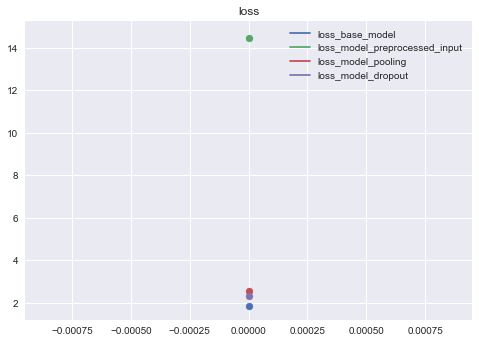

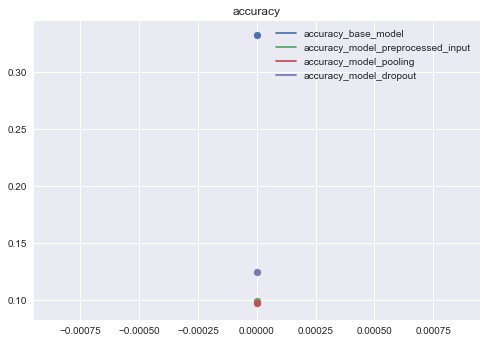

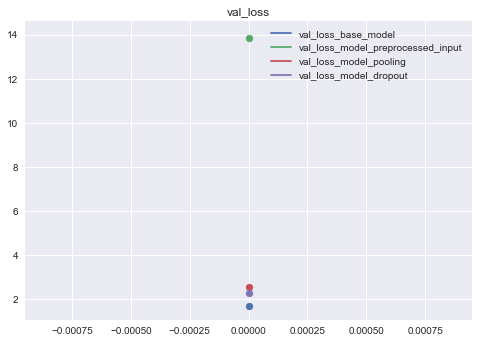

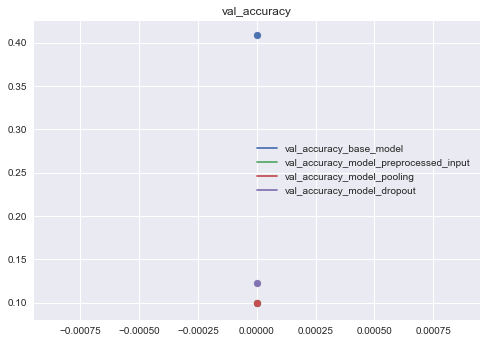

In [100]:
# Use plotHistory to make these plots
plotHistory(lr_histories, model_names, "loss")
plotHistory(lr_histories, model_names, "accuracy")
plotHistory(lr_histories, model_names, "val_loss")
plotHistory(lr_histories, model_names, "val_accuracy")

Analysis: The results above show that a learning rate of 0.001 has the least loss and most accuracy because it is not too big like 2 to cause potential overshooting and isn't very small as to slow down gradient descent to low levels.